In [1]:
import sys
sys.executable

'/Users/benjaminlevy/Desktop/Benjamin/School/19_20/Classes/spring/ac221/final-project/covid-tracking-env/bin/python'

In [2]:
%load_ext autoreload
%autoreload 2

# Visualization

In [3]:
import re
from datetime import date, timedelta, datetime
from textwrap import dedent

import pandas as pd
import numpy as np
import scipy.stats as sps
import lowess

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib import rc
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn as sns

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import chart_studio as cs
import chart_studio.plotly as py

import pyperclip

from tracking import config, utils, plotting

from IPython.display import display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
pio.templates.default = "plotly_white"
sns.set(style='whitegrid', font_scale=1.5)

In [5]:
# rc('font',**{'family':'sans-serif','sans-serif': ['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif': ['Palatino']})
rc('text', usetex=True)

## Loading data

In [6]:
df_scored = pd.read_csv(config.data / 'apps_scored.csv', index_col=0)
df_scored['date_released'] = pd.to_datetime(df_scored['date_released'])

In [7]:
utils.display_all(df_scored.head())

Name     Country  \
0         COVIDSafe   Australia   
1      Stopp Corona     Austria   
2           BeAware     Bahrain   
3  Corona Tracer BD  Bangladesh   
4    Romware Radius     Belgium   

                                               Links government  \
0  https://www.health.gov.au/resources/apps-and-t...        yes   
1  https://www.roteskreuz.at/site/faq-app-stopp-c...        yes   
2  https://play.google.com/store/apps/details?id=...        yes   
3  https://play.google.com/store/apps/details?id=...        yes   
4                 https://rombit.be/covid-solutions/         no   

   11_defined_lifetime  12_storage_time_limited  21_opt_in_download_use  \
0                    1                        1                       1   
1                    1                        1                       1   
2                    0                        0                       0   
3                    0                        1                       1   
4                    0                        1                       0   

   22_opt_in_share  23_other_benefits  31_only_contacts  32_no_pii  \
0                1                  1                 1          0   
1                1                  1                 1          1   
2                0                  0                 0          0   
3                1                  1                 0          0   
4                0                  0                 1          0   

   41_open_source  42_privacy_policy  51_free  52_android_ios  \
0               1                  1        1               1   
1               1                  1        1               1   
2               0                  0        1               1   
3               0                  1        1               1   
4               0                  0        0               0   

   61_decentralized_storage  62_erase_data  71_decentralized_matching  \
0                         0              1                          0   
1                         1              1                          1   
2                         0              0                          0   
3                         1              1                          1   
4                         0              0                          0   

   72_rotating_randomized  81_ble_only  82_verify_test      protocol  \
0                       1            1               1          none   
1                       1            1               0  Apple/Google   
2                       0            0               1          none   
3                       1            0               0          none   
4                       0            0               0          none   

  Installs (Google Play)  Average Rating (Google Play) who_region    status  \
0              1,000,000                           3.1       WPRO  released   
1                100,000                           3.3       EURO  released   
2                100,000                           4.5       EMRO  released   
3                500,000                           3.5      SEARO  released   
4                    NaN                           NaN       EURO  released   

  date_released date_cancelled has_protocol state protocol_other  score  
0    2020-04-26            NaN           no   NaN           none    6.5  
1    2020-03-27            NaN          yes   NaN   Apple/Google    7.5  
2    2020-04-09            NaN           no   NaN           none    1.5  
3    2020-06-03            NaN           no   NaN           none    5.0  
4           NaT            NaN           no   NaN           none    1.0

## Number of apps released over time

By

* Protocol
* Region

(small multiples)

In [8]:
days = pd.date_range(config.start_date, config.end_date)

protocols = df_scored['protocol_other'].unique()
counts = []
displaydata = df_scored.query('~@pd.isna(date_released)')

def count_time_series(df):
    counts = []
    for d in days:
        day_data = {
            'day': d,
            'count': sum(df['date_released'] <= d)
        }
        counts.append(day_data)
    return pd.DataFrame(counts)


def group_and_count(df, groupvars):
    return df.groupby(groupvars).apply(count_time_series).reset_index(groupvars)

df_protocol = group_and_count(displaydata, 'protocol_other')
df_region = group_and_count(displaydata, 'who_region')
df_region_protocol = group_and_count(displaydata, ['who_region', 'protocol_other'])

In [9]:
df_scored.who_region.unique()

array(['WPRO', 'EURO', 'EMRO', 'SEARO', 'NORAM', 'LATAM', 'AFRO', nan],
      dtype=object)

In [10]:
df_scored[pd.isna(df_scored.date_released)]

Name        Country  \
4                                 Romware Radius        Belgium   
10                                        Unmaze       Bulgaria   
12                                       MyTrace         Canada   
13                                          Covi         Canada   
16                                         flaat         Canada   
17   Alipay Health Code + Close Contact Detector          China   
25                                       CoCOVID             EU   
30                                     Corona GO        Germany   
31                                         OHIOH        Germany   
32                                        Cotect        Germany   
34                                        Pandoa        Germany   
35                                           Ito        Germany   
37                                   my co:radar        Germany   
38                                        Plinks        Germany   
41                         Covid Community Alert         Global   
47                                        Unmaze          India   
54                                       Mask.ir           Iran   
56                                   Code Orange         Israel   
61                                         diAry          Italy   
77                                 PrivateTracer    Netherlands   
90                                Contact Tracer         Russia   
95                                   Daancovid19        Senegal   
97                                         CovCT      Singapore   
102                          Corona 100m (Co100)    South Korea   
103                             Open Coronavirus          Spain   
114                                    SafeTrace  United States   
115                                  CoronaTrace  United States   
119                                        CoEpi  United States   
120                                        Safe2  United States   
121                                  COVID Watch  United States   
143                Oregon Exposure Notifications  United States   
145                             Rastrea El Virus  United States   

                                                 Links government  \
4                   https://rombit.be/covid-solutions/         no   
10                        http://cyborgsys.com/unmaze/         no   
12                             https://www.mytrace.ca/         no   
13   https://covicanada.org/?gclid=CjwKCAjw8J32BRBC...         no   
16                               https://app.flaat.io/         no   
17   https://www.nytimes.com/2020/03/01/business/ch...        yes   
25                               https://cocovid.info/         no   
30                               https://corona-go.de/         no   
31                                   https://ohioh.de/         no   
32                       https://cotect.launchaco.com/         no   
34                                 https://pandoa.org/         no   
35                            https://www.ito-app.org/         no   
37                  http://mycoradar.de/my-coradar-eu/         no   
38                                  https://plinks.io/         no   
41   https://coronavirus-outbreak-control.github.io...         no   
47   https://www.expresscomputer.in/news/indian-ai-...         no   
54                            https://mask.ir/faq.html        yes   
56   https://docs.google.com/document/d/1Nv_Uxt3ATy...        yes   
61   https://covid19app.uniurb.it/en/diary-lets-sto...         no   
77                      https://www.privatetracer.org/         no   
90                           https://contacttracer.ru/         no   
95                             https://daancovid19.sn/        yes   
97                                  https://covct.org/         no   
102  https://play.google.com/store/apps/details?id=...        yes   
103                       https://opencoronavirus.app/         no   
114             https://github.com/eni

In [11]:
def plot_stacked_area(df, col, cmap='Reds', ax=None, levels=None, legend=False, offsets=None, stacked=False, **kwargs):
    ax = ax or plt.gca()
    if offsets is None:
        offsets = {}
    if type(cmap) == str:
        cmap = sns.color_palette(cmap)
    plot_data = df.pivot(index='day', columns=col, values='count')
    
    if levels is not None:
        color_dict = {level: color for level, color in zip(levels, cmap)}
        cmap = [color_dict[col] for col in levels]
        plot_data = plot_data[[l for l in levels if l in plot_data.columns]]
    
    if stacked:
        ax.stackplot(plot_data.index, plot_data.values.T, colors=cmap)
    else:
        for column, color in zip(plot_data.columns, cmap):
            ax.plot(plot_data.index, plot_data[column], c=color)
    ax.grid(b=None)
    
    date_fmt = mdates.DateFormatter('%b %Y')
    ax.xaxis.set_major_formatter(date_fmt)
    
    # Annotating instead of legend
    if legend:
        patches = [mpatches.Patch(label=c, color=color) for c, color in zip(plot_data.columns, cmap)][::-1]
        ax.legend(title=col, handles=patches, loc='upper left', fontsize='xx-small')
    else:
        # Extending by 1 month
        x0, x1 = ax.get_xlim()
        ax.set_xlim(x0, x1 + 30)
        
        bottom = 0.
        for level, color in zip(plot_data.columns, cmap):
            if level in plot_data.columns:
                val = plot_data[level].max()
                xoff, yoff = offsets.get(level, (0, 0))
                coords = (x1 + xoff, val + yoff)
                level_cap = level[0].upper() + level[1:]
                
                ax.annotate(level_cap, coords, color=color, va='center', size='small')

    plotting.remove_spines(ax, spines=['top', 'right'])

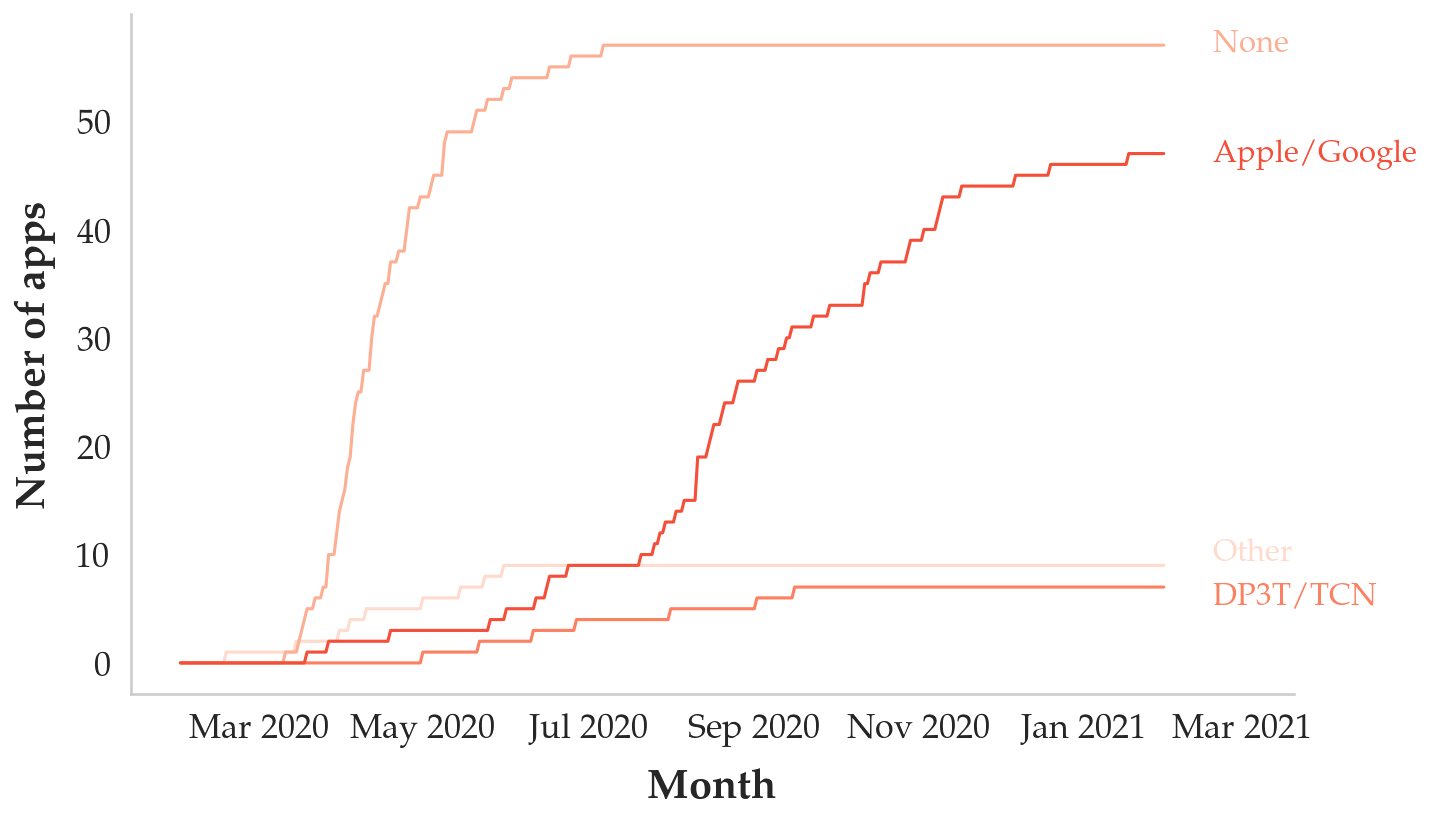

In [12]:
plt.figure(dpi=150, figsize=(10, 6))
plot_stacked_area(
    df_protocol.rename(columns={'protocol_other': 'Protocol'}),
    'Protocol',
    levels=['other', 'none', 'DP3T/TCN', 'Apple/Google'],
    offsets={
        'other': (0, 1),
        'DP3T/TCN': (0, -1)
    }
)

plt.xlabel(r"\textbf{Month}", fontsize=20, labelpad=10)
plt.ylabel(r"\textbf{Number of apps}", fontsize=20, labelpad=10);

By region

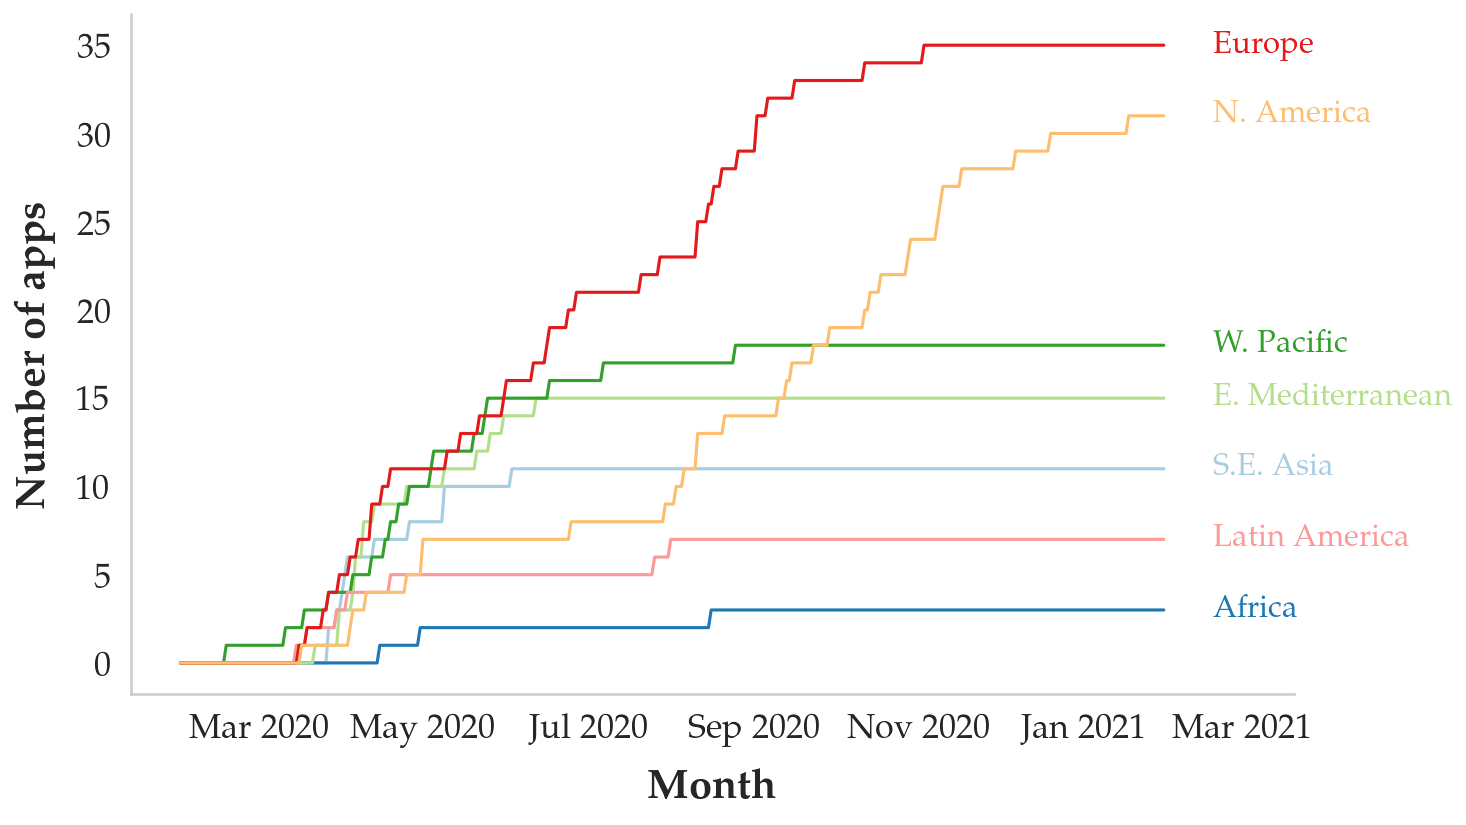

In [13]:
plt.figure(dpi=150, figsize=(10, 6))
region_dict = {
    'WPRO': 'W. Pacific',
    'SEARO': 'S.E. Asia',
    'NORAM': 'N. America',
    'LATAM': 'Latin America',
    'EURO': 'Europe',
    'EMRO': 'E. Mediterranean',
    'AFRO': 'Africa'
}

regions = [
    'S.E. Asia',
    'Africa',
    'E. Mediterranean',
    'W. Pacific',
    'Latin America',
    'Europe',
    'N. America',
]

displaydata = df_region.assign(region=df_region['who_region'].replace(region_dict))
plot_stacked_area(
    displaydata.rename(columns={'region': 'Region'}),
    'Region',
    cmap='Paired',
    levels=regions
)

plt.xlabel(r"\textbf{Month}", fontsize=20, labelpad=10)
plt.ylabel(r"\textbf{Number of apps}", fontsize=20, labelpad=10);

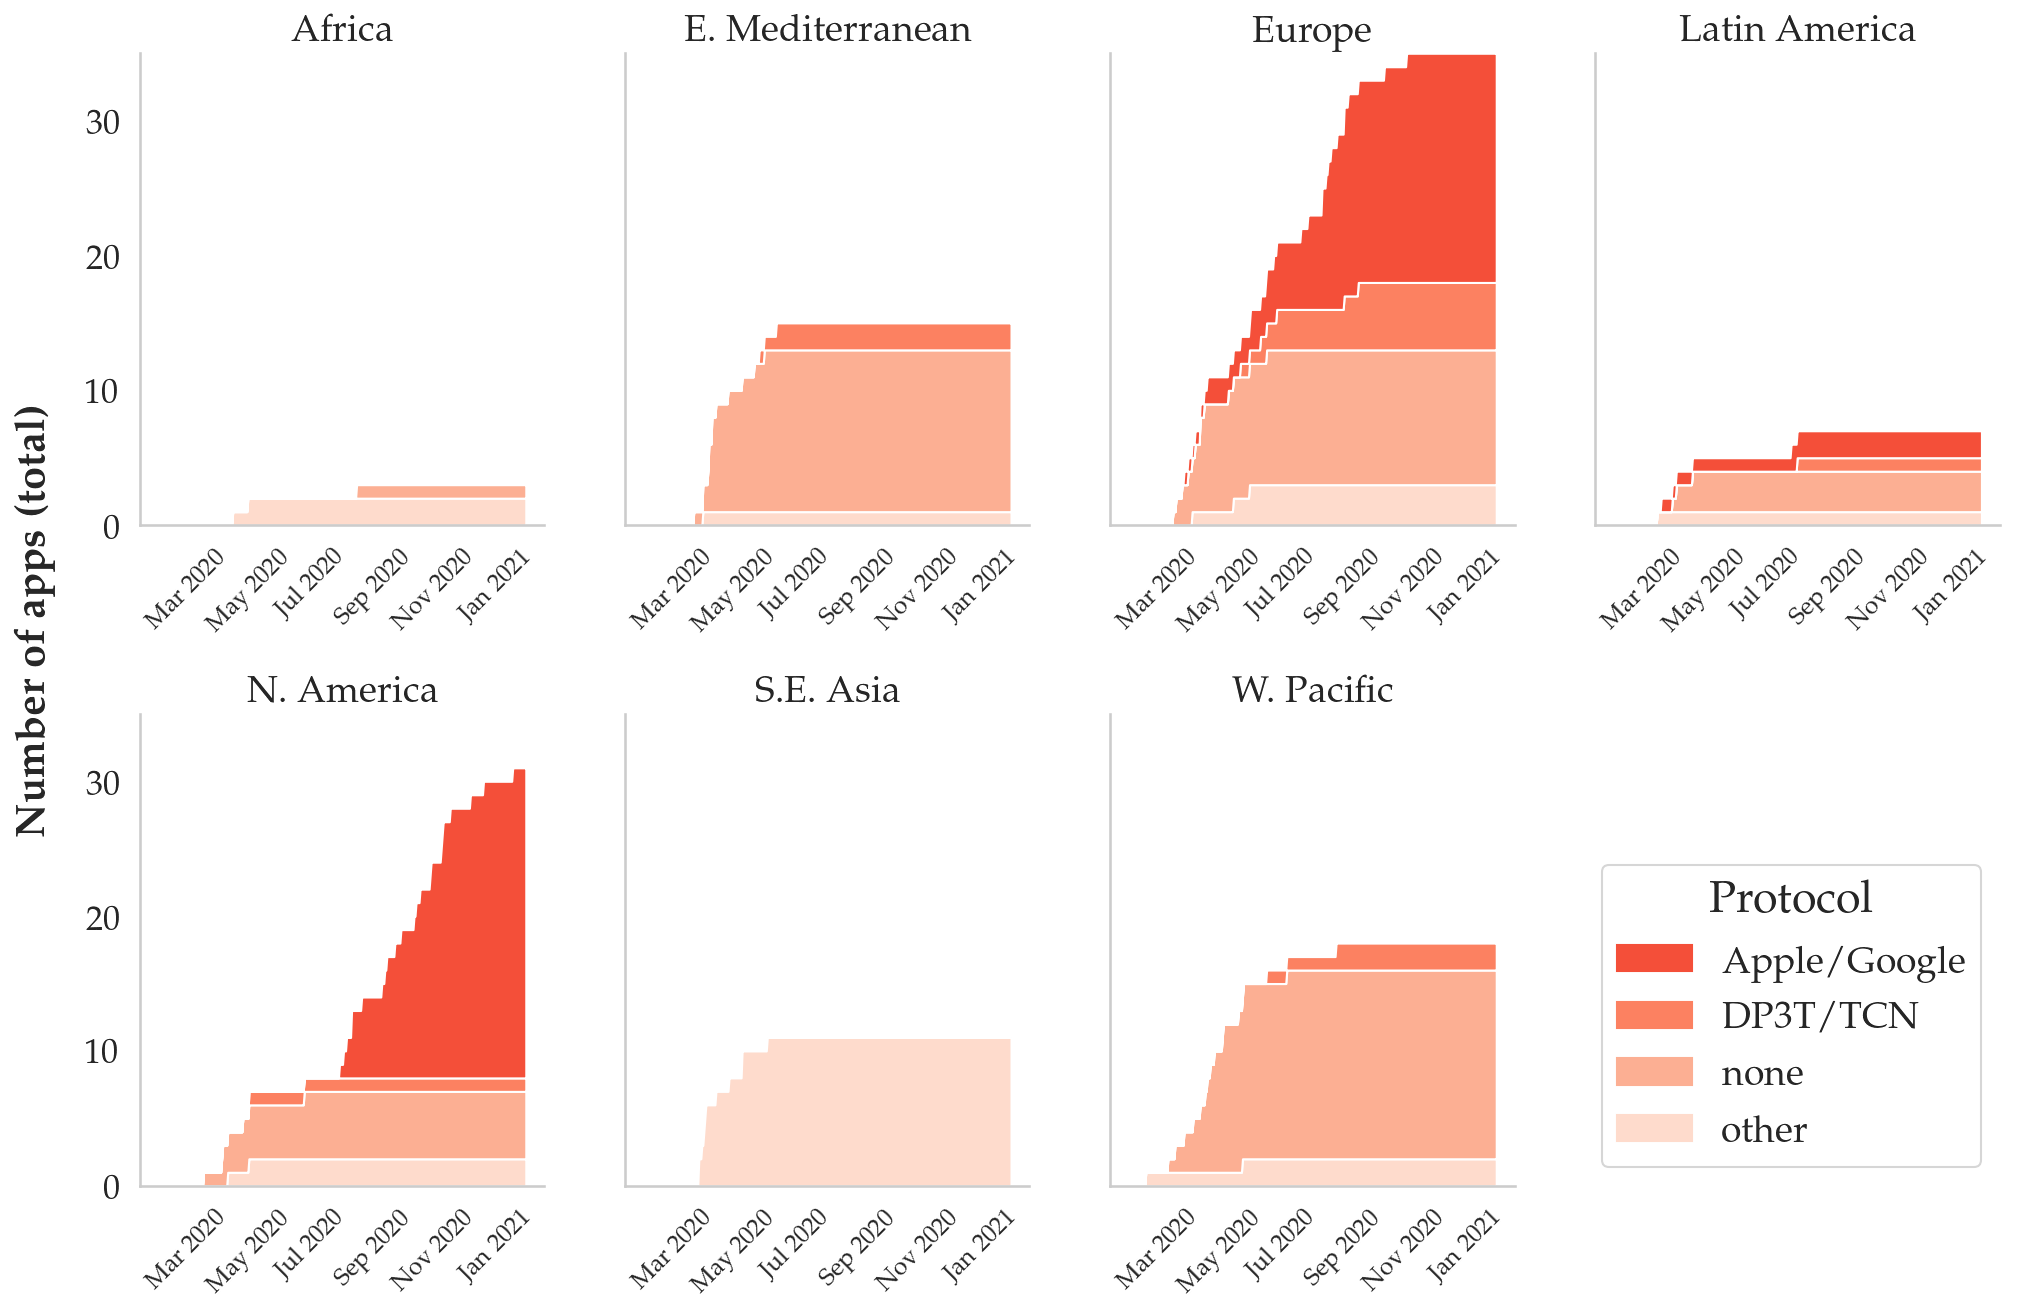

In [14]:
regions = df_region_protocol['who_region'].unique()
protocols = ['other', 'none', 'DP3T/TCN', 'Apple/Google']
ncols = 4
nrows = int(np.ceil(len(regions) / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 10), dpi=150, sharex=False, sharey=True)

for ax, region in zip(axs.flat, regions):
    subset = df_region_protocol.query('who_region == @region').drop('who_region', axis=1)
    plot_stacked_area(
        subset,
        'protocol_other',
        ax=ax,
        cmap='Reds',
        alpha=0.9,
        levels=protocols,
        legend=True,
        stacked=True
    )
    ax.set_title(region_dict[region])
    ax.set_ylim(0, 35)
    
    ax.tick_params(axis='x', labelrotation=45, labelsize=12)
    ax.get_legend().remove()

# Hiding everything but the legend
ax = axs[1, 3]
ax.grid(b=None)
plotting.remove_spines(ax)
ax.set_xticks([])
cmap = sns.color_palette('Reds')
patches = [mpatches.Patch(label=c, color=color) for c, color in zip(protocols, cmap)][::-1]
ax.legend(title='Protocol', handles=patches, loc='lower right', fontsize='medium', title_fontsize='large')

fig.subplots_adjust(hspace=0.4)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.grid(b=None)

plt.ylabel(r"\textbf{Number of apps (total)}", fontsize=20, labelpad=10);

By country

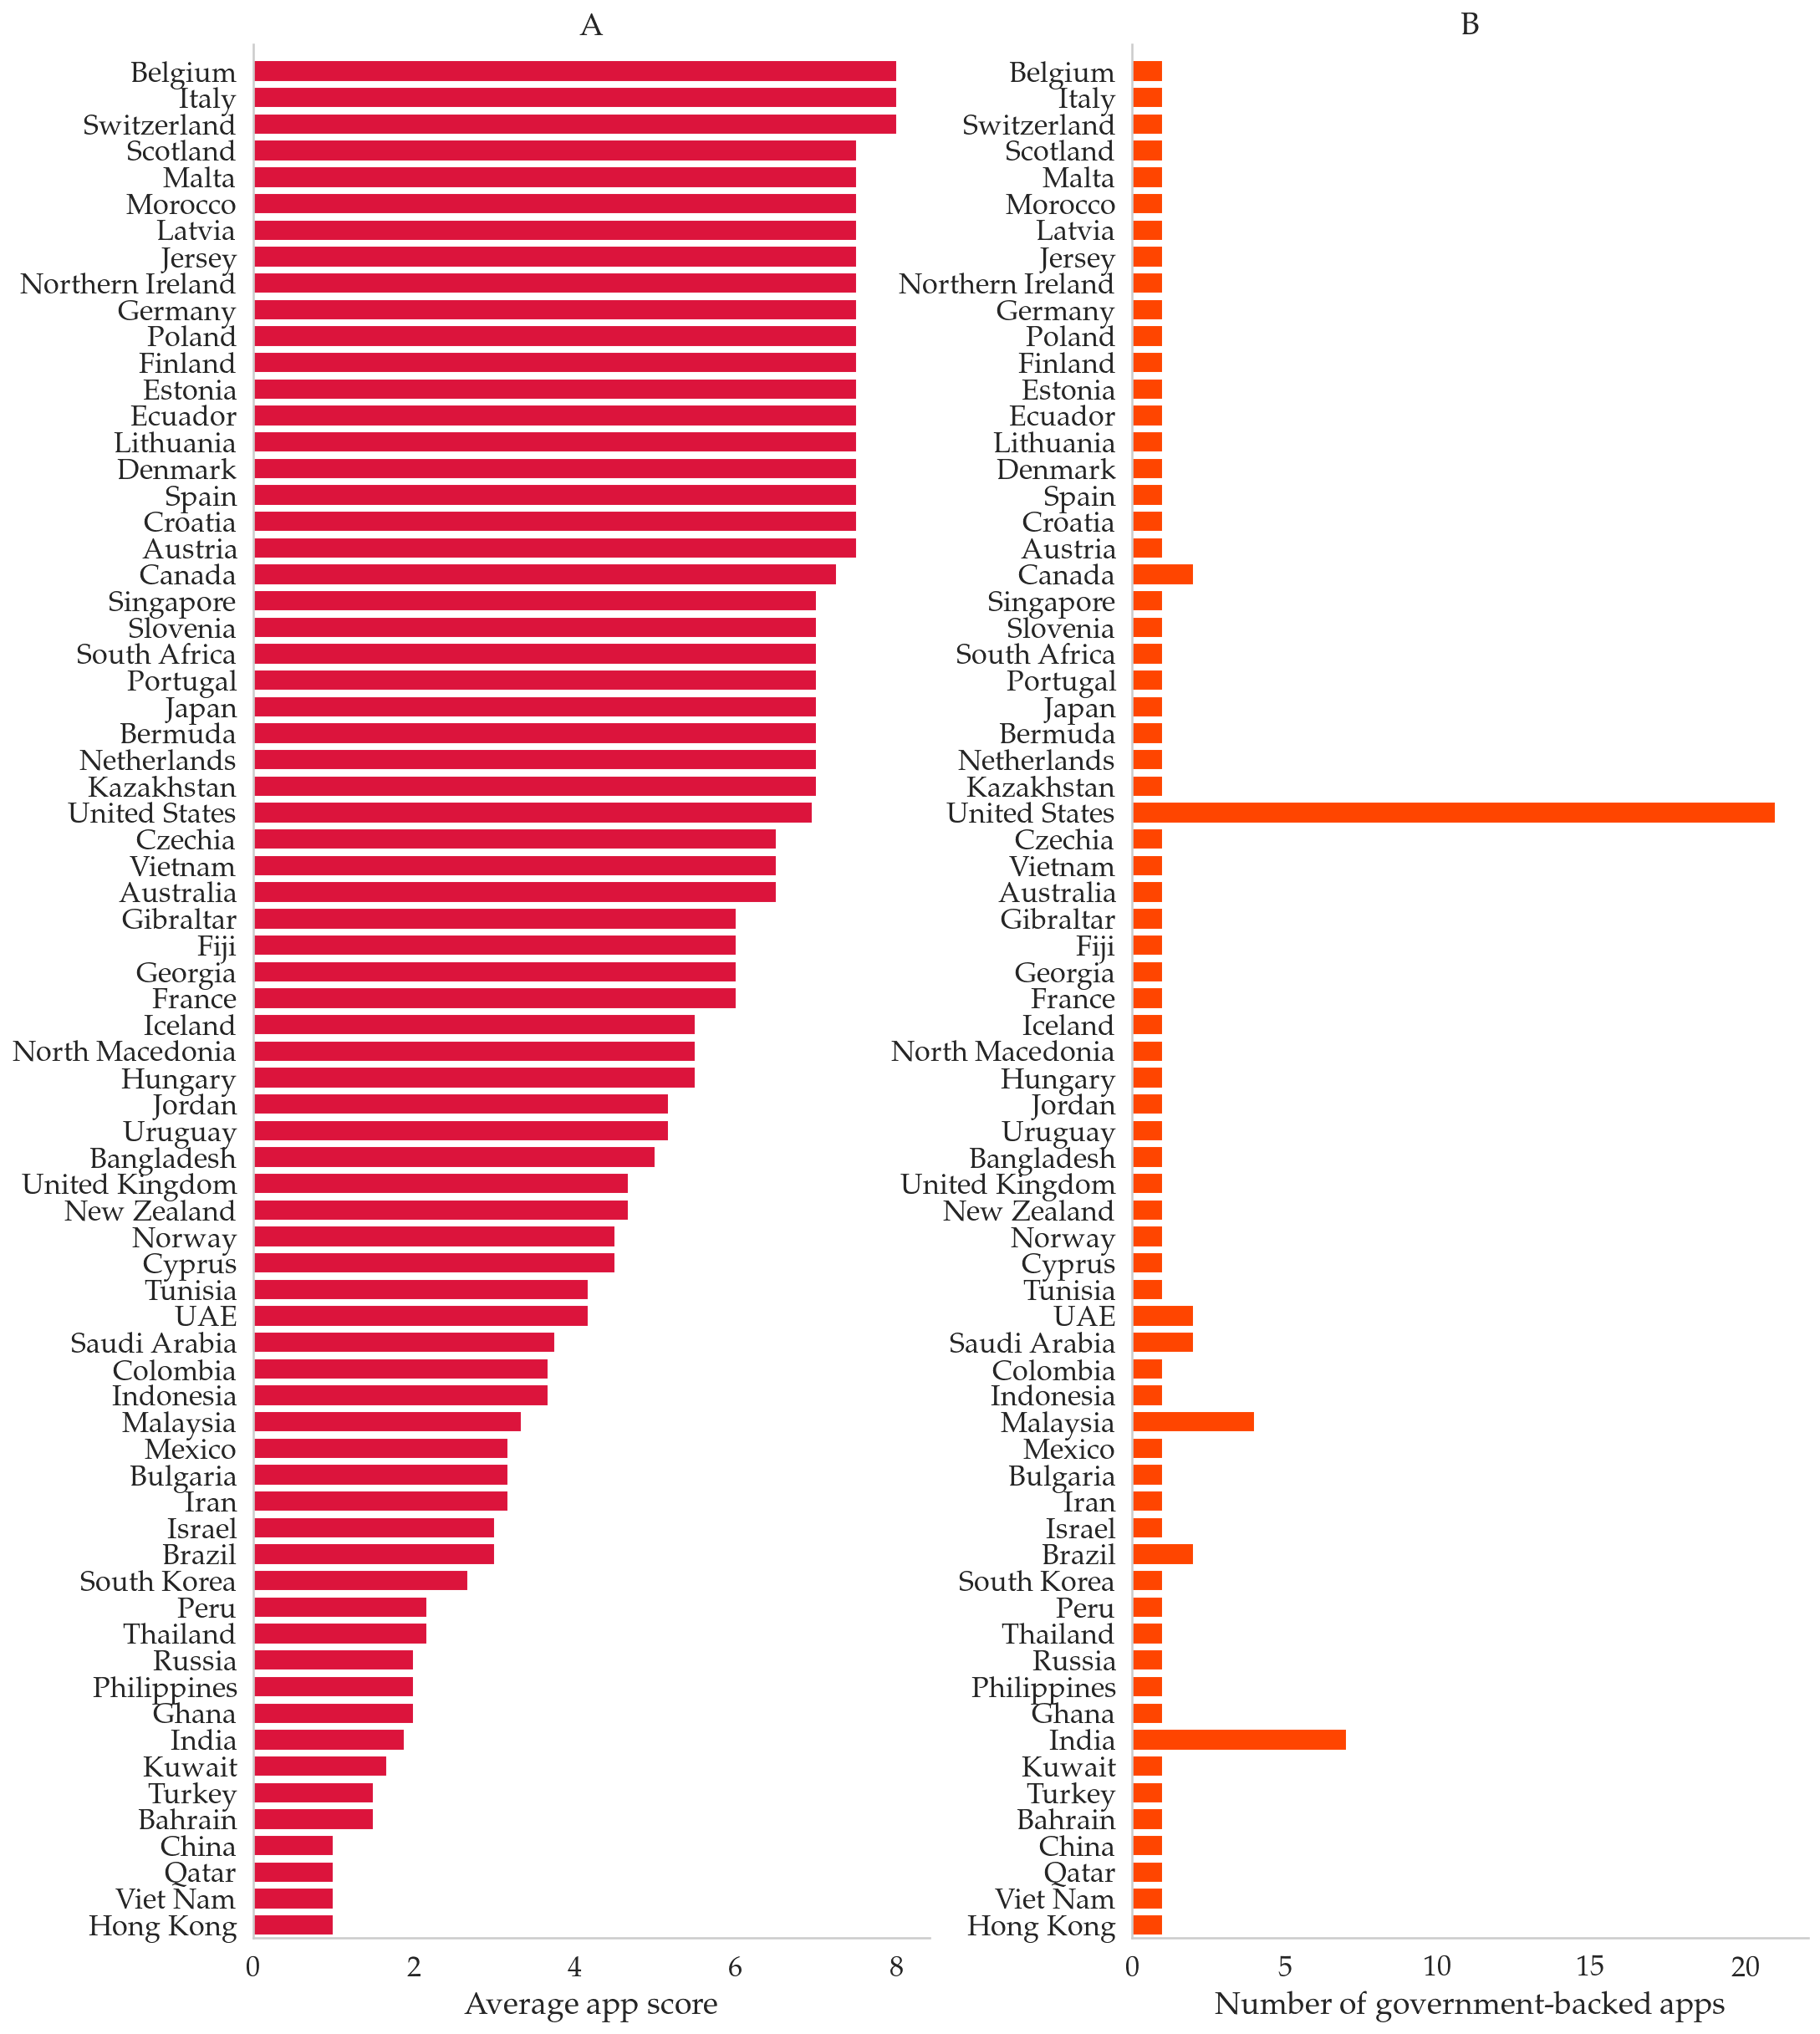

In [15]:
displaydata = (df_scored
               .query('government == "yes"')
               .query('~@pd.isna(score)')
               .query('status == "released"')
               .groupby('Country')
               .agg({'score': ['mean', 'count']}))

displaydata.columns = ['mean', 'count']
displaydata = displaydata.sort_values('mean', ascending=True)

fig, axs = plt.subplots(1, 2, figsize=(16, 20), dpi=150)

for column, ax, color, title, xtitle in zip(
    ['mean', 'count'],
    axs,
    ['crimson', 'orangered'],
    ['A', 'B'],
    ['Average app score', 'Number of government-backed apps']
):
    ax.barh(displaydata.index, displaydata[column], color=color)
    ax.grid(b=None)
    plotting.remove_spines(ax, spines=['top', 'right'])
    ax.set_ylim(-0.5, displaydata.shape[0]);
    ax.set_title(title)
    ax.set_xlabel(xtitle)

fig.subplots_adjust(wspace=0.3);

Region and protocol

## Question responses over time

Dot plot

In [16]:
displaydata = df_scored

In [17]:
question2col = {
    "1.1. App has defined lifetime": "11_defined_lifetime",
    "1.2. Data storage is time-limited": "12_storage_time_limited",
    "2.1. Opt-in download and use": "21_opt_in_download_use",
    "2.2. Opt-in data sharing": "22_opt_in_share",
    "2.3. Not tied to other benefits": "23_other_benefits",
    "3.1. Data used only for establishing contacts": "31_only_contacts",
    "3.2. No PII collection": "32_no_pii",
    "4.1. Open source": "41_open_source",
    "4.2. Published privacy policy": "42_privacy_policy",
    "5.1. Freely available": "51_free",
    "5.2. Android and iOS (when necessary)": "52_android_ios",
    "6.1. Decentralized storage": "61_decentralized_storage",
    "6.2. Can erase data": "62_erase_data",
    "7.1. Decentralized matching": "71_decentralized_matching",
    "7.2. Rotating randomized beacon": "72_rotating_randomized",
    "8.1. Contact accuracy (BLE, not GPS or other)": "81_ble_only",
    "8.2. Positive cases verified by test": "82_verify_test",
}

col2question = {c: q for q, c in question2col.items()}

questions = list(col2question.keys())
question2idx = {q: i for i, q in enumerate(questions)}
palette = ['red', 'blue']
plot_data = (displaydata.melt(id_vars=['date_released', 'Name', 'Country', 'score', 'protocol'],
                              value_vars=questions, var_name='question')
             .query('~@pd.isnull(date_released)')
             .fillna(0)
             .assign(y=lambda df: df['question'].apply(lambda x: question2idx[x]))
             .assign(response=lambda df: df['value'].replace({0: 'no', 1: 'yes'}))
             .assign(question_text=lambda df: df['question'].replace(col2question))
             .assign(value=lambda df: df['value'].replace({0.0: 'no', 1.0: 'yes'})))

In [18]:
fig = px.scatter(plot_data, x='date_released', y='y', color='value',
                 color_continuous_scale=['red', 'blue'],
                 hover_name='Name',
                 hover_data=['Country', 'protocol', 'score', 'response', 'question_text'],
                 labels={'value': 'Response'},
                 opacity=0.6
                )

fig.update(layout_coloraxis_showscale=False,
           layout_title="App results",
           layout_xaxis_title="Date released",
           layout_yaxis_title="Question",
           layout_xaxis=dict(
               gridcolor='gainsboro'
           ),
           layout_yaxis=dict(
               tickmode='array',
               tickvals=np.arange(len(questions)),
               ticktext=list(question2col.keys()),
               gridcolor='gainsboro'
           ),
           layout_font=dict(color='black'),
           layout_height=800
          )

fig.update_traces(hovertemplate=dedent('''
    Country: %{customdata[0]}<br>
    protocol: %{customdata[1]}<br>
    score: %{customdata[2]:.2f}<br>
    question: %{customdata[4]}<br>
    response: %{customdata[3]}
'''))

fig.show()

In [19]:
plot_data

date_released                      Name        Country     score  \
0       2020-04-26                 COVIDSafe      Australia  6.500000   
1       2020-03-27              Stopp Corona        Austria  7.500000   
2       2020-04-09                   BeAware        Bahrain  1.500000   
3       2020-06-03          Corona Tracer BD     Bangladesh  5.000000   
5       2020-09-16                Coronalert        Belgium  8.000000   
...            ...                       ...            ...       ...   
2579    2020-10-28                 WA Notify  United States  7.000000   
2580    2020-12-20  WI Exposure Notification  United States  7.000000   
2581    2020-03-19            Coronavirus UY        Uruguay  5.166667   
2582    2020-03-11                     NCOVI       Viet Nam  1.000000   
2583    2020-04-17                  BlueZone        Vietnam  6.500000   

          protocol             question value   y response  \
0             none  11_defined_lifetime   yes   0      yes   
1     Apple/Google  11_defined_lifetime   yes   0      yes   
2             none  11_defined_lifetime    no   0       no   
3             none  11_defined_lifetime    no   0       no   
5             DP3T  11_defined_lifetime   yes   0      yes   
...            ...                  ...   ...  ..      ...   
2579  Apple/Google       82_verify_test   yes  16      yes   
2580  Apple/Google       82_verify_test   yes  16      yes   
2581  Apple/Google       82_verify_test   yes  16      yes   
2582          none       82_verify_test    no  16       no   
2583          none       82_verify_test   yes  16      yes   

                             question_text  
0            1.1. App has defined lifetime  
1            1.1. App has defined lifetime  
2            1.1. App has defined lifetime  
3            1.1. App has defined lifetime  
5            1.1. App has defined lifetime  
...                                    ...  
2579  8.2. Positive cases verified by test  
2580  8.2. Positive cases verified by test  
2581  8.2. Positive cases verified by test  
2582  8.2. Positive cases verified by test  
2583  8.2. Positive cases verified by test  

[2040 rows x 10 columns]

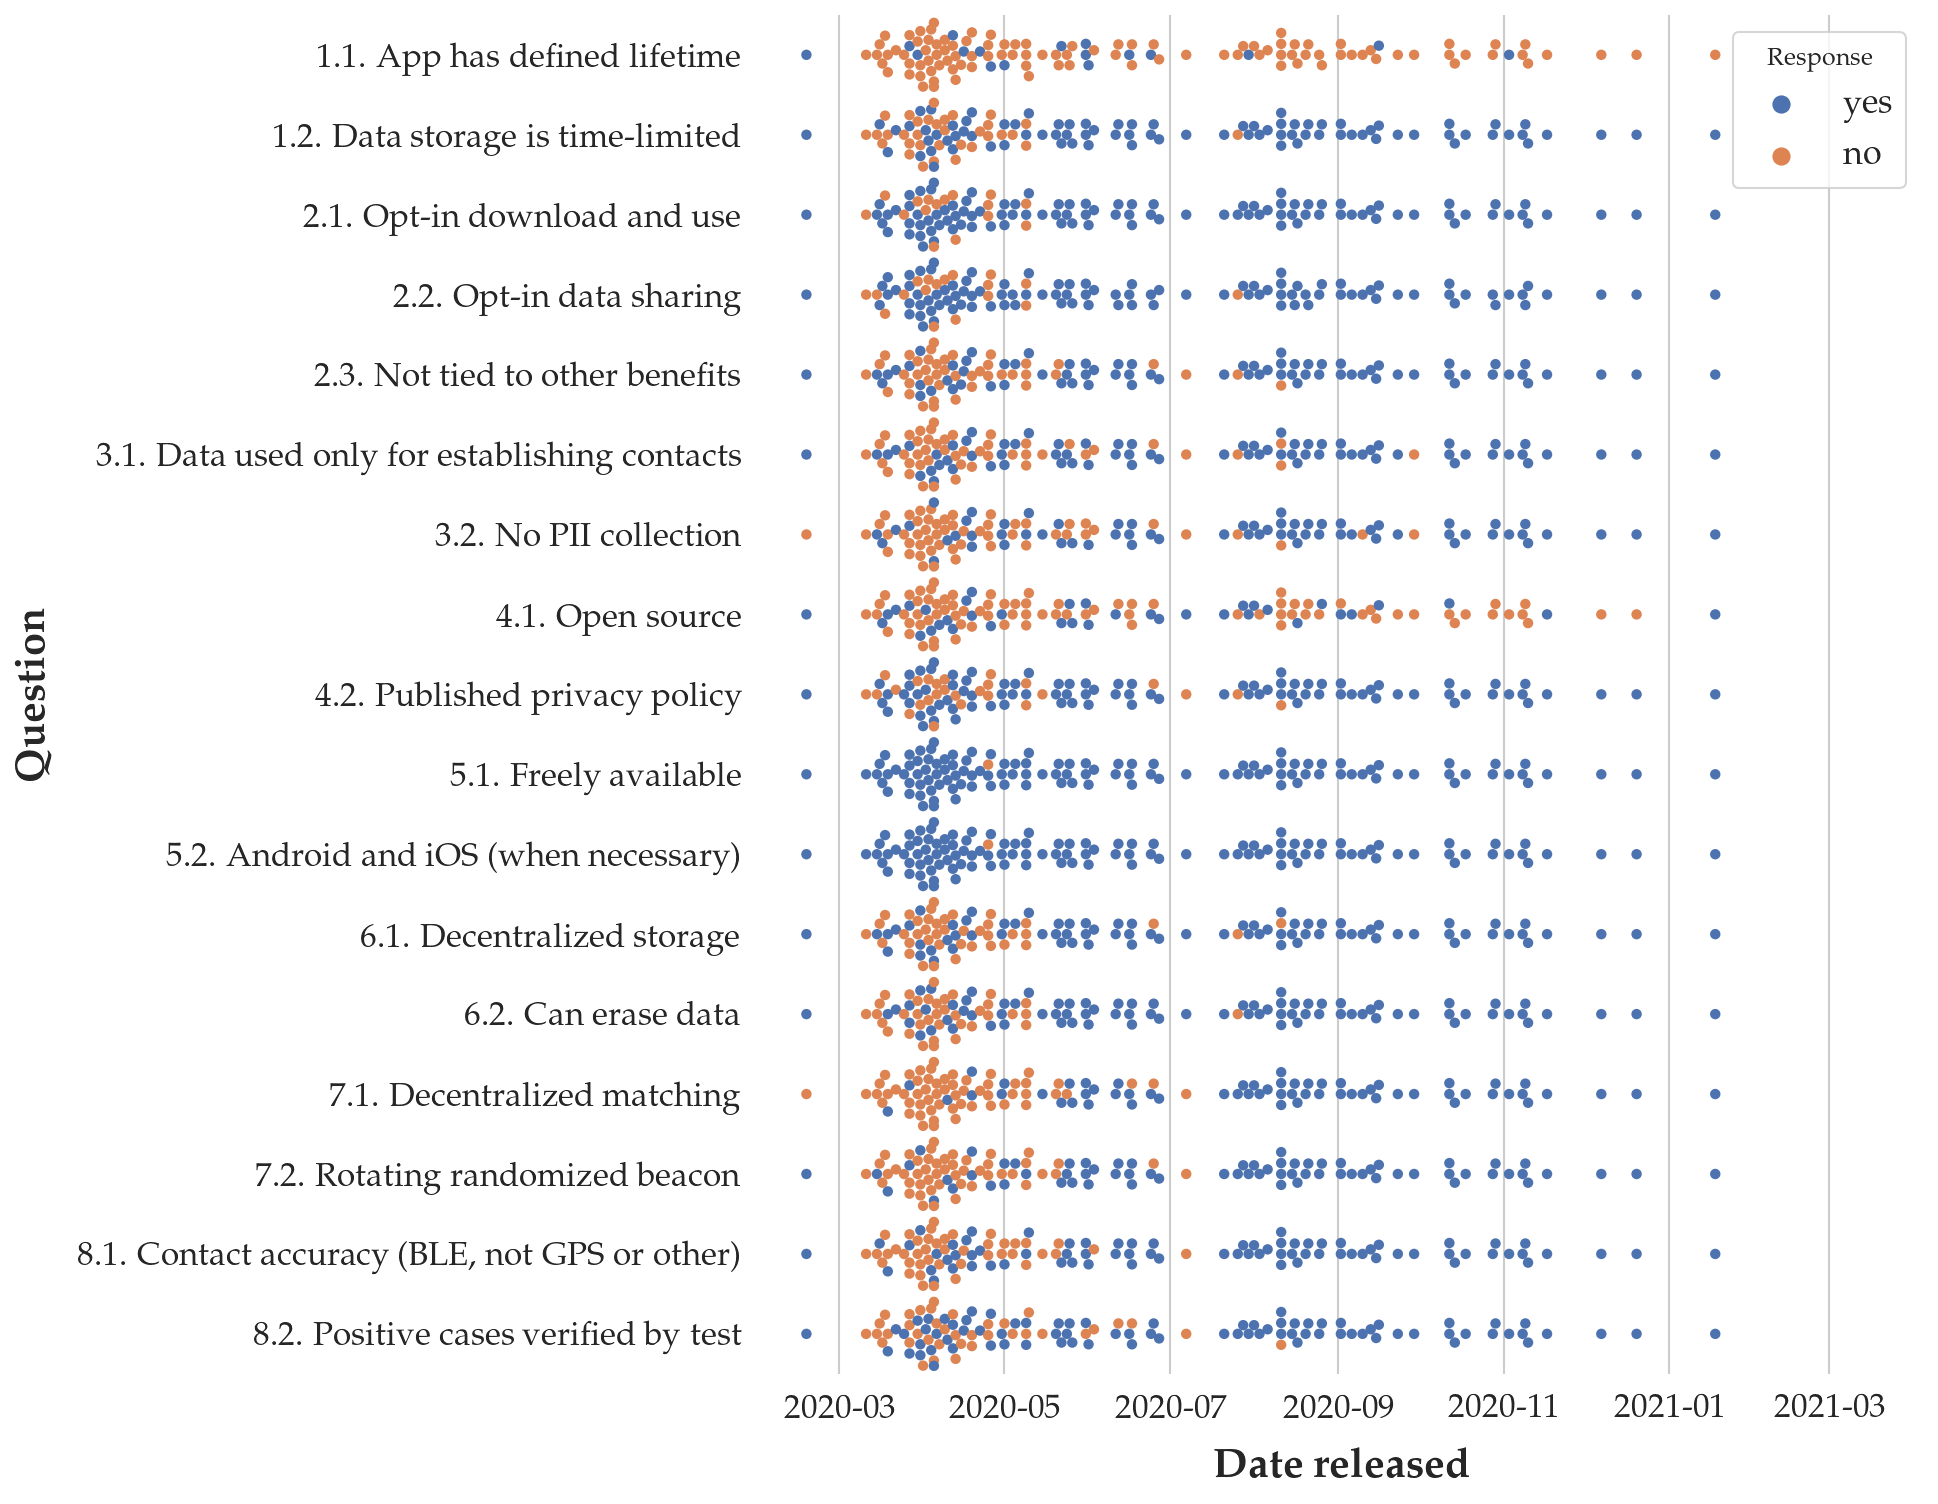

In [20]:
plt.figure(figsize=(10, 12), dpi=150)

sns.swarmplot(
    data=plot_data,
    y='question_text',
    x='date_released',
    hue='response'
)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r"\textbf{Date released}", fontsize=20, labelpad=10)
plt.ylabel(r"\textbf{Question}", fontsize=20, labelpad=10)

# Extending by 1 month
x0, x1 = plt.gca().get_xlim()
plt.xlim(x0, x1 + 60)

plt.legend(title="Response")

plotting.remove_spines(plt.gca())

## Looking at score vs. date released

In [21]:
null_flag = np.logical_and(~pd.isna(df_scored['date_released']), ~pd.isna(df_scored['score']))
displaydata = df_scored.loc[null_flag, ['Name', 'Country', 'date_released', 'score']].sort_values('date_released')
dates = pd.to_datetime(displaydata['date_released'])
firstdate = min(dates)
x = (dates - firstdate).apply(lambda x: x.days).values
y = displaydata['score'].values

hovertemplate = '''
<b>%{text}</b><br><br>
Score: %{y:.1f}<br>
Date released: %{x}
<extra></extra>
'''

fig = go.Figure(data=go.Scatter(x=dates, y=y, mode='markers',
                                hovertemplate=hovertemplate,
                                text=displaydata.apply(lambda row: f'{row["Name"]} ({row["Country"]})', axis=1),
                                showlegend=False))

# LOWESS
yy = lowess.lowess(pd.Series(x[1:]), pd.Series(y[1:]), bandwidth=0.4)
fig.add_trace(go.Scatter(x=dates, y=yy,
                         mode='lines', name='LOWESS<br>(bandwidth = 0.4)',
                         line_color='gray', hoverinfo='none'))

fig.update_layout(
    xaxis={'title':'Date', 'gridcolor': 'gainsboro'},
    yaxis={'title':'App score', 'gridcolor': 'gainsboro'},
#     title="App score by release date",
    modebar=None,
    font=dict(color='black'),
    font_family="Palatino",
    font_size=20
)

fig.show()

## Looking at the United States

In [22]:
df_us = df_scored.query('Country == "United States"')

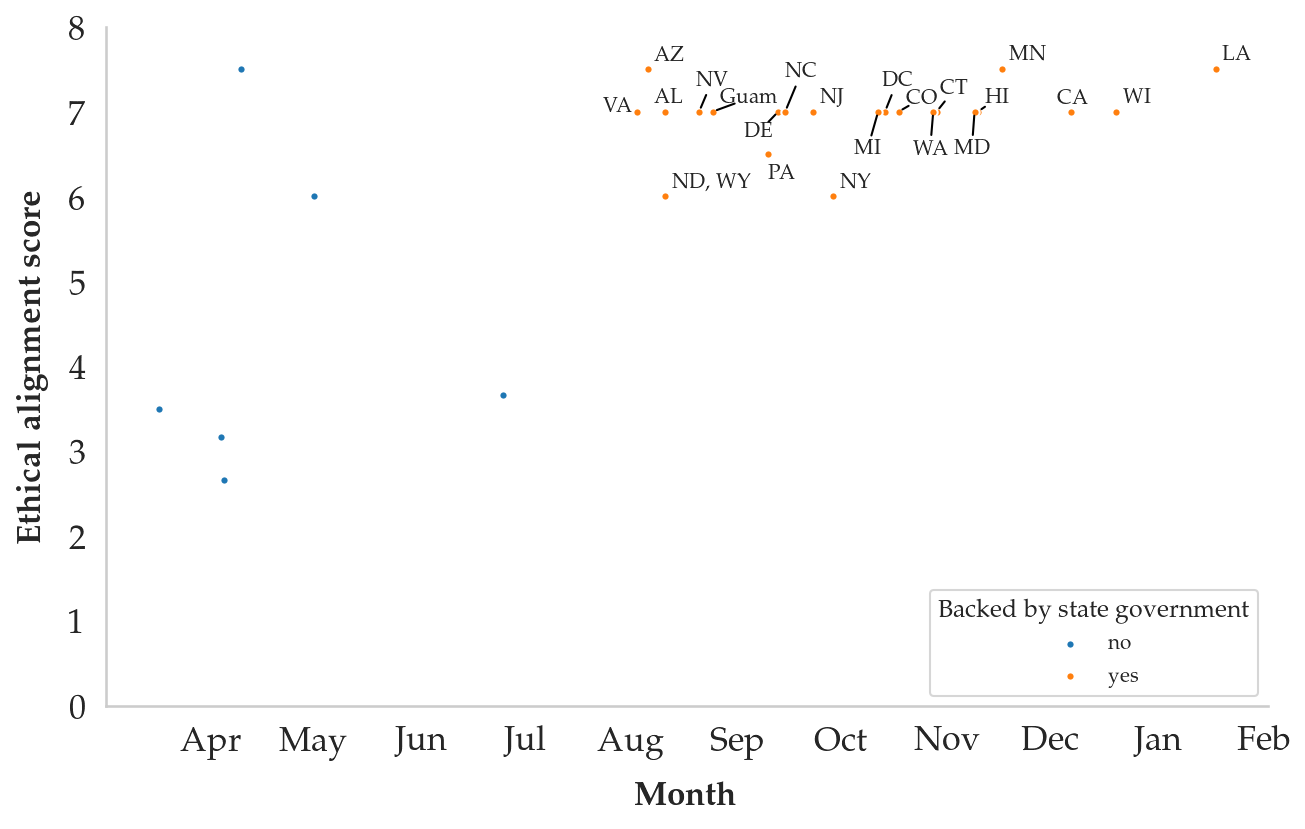

In [166]:
plt.figure(dpi=150, figsize=(10, 6))
for gov, color in zip(['no', 'yes'], ['tab:blue', 'tab:orange']):
    subset = df_us.query('government == @gov')
    plt.scatter(
        subset['date_released'],
        subset['score'],
        label=gov,
        s=16,
        marker='o',
        edgecolor='white',
        color=color
    )
plt.legend(title='Backed by state government', fontsize=10, loc='lower right')
plotting.remove_spines(plt.gca(), spines=['top', 'right'])
plt.grid(b=None)
plt.ylabel('Ethical alignment score')
plt.xlabel("Release date")

offsets = {
    'DE': (timedelta(days=-10), -.3),
    'NC': (timedelta(days=-1), .05),
    'MI': (timedelta(days=-7), -.5),
    'MD': (timedelta(days=-6), -.5),
    'WA': (timedelta(days=-6), -.5),
    'CT': (timedelta(days=1), .2),
    'NV': (timedelta(days=-1), .3),
    'DC': (timedelta(days=-1), .3),
    'VA': (timedelta(days=-10), 0),
    'AL': (timedelta(days=-3), 0.1),
    'CA': (timedelta(days=-4), 0.1),
    'NC': (timedelta(days=0), 0.4),
    'PA': (timedelta(days=0), -0.3)
}

lines = [
    'MI',
    'MD',
    'CT',
    'DC',
    'NV',
    'WA',
    'Guam',
    'DE',
    'CO',
    'HI',
    'NC'
]

for idx, row in df_us.query('government == "yes"').query('~@pd.isna(date_released)').iterrows():
    s = row['state']
    xoff, yoff = offsets.get(s, (timedelta(days=2), .1))
    x = row['date_released']
    y = row['score']
    xtext = x + xoff
    ytext = y + yoff
    
    if s in lines:
        arrowprops = dict(
            arrowstyle= '-',
            ls= '-',
            linewidth=1,
            color='black',
            patchA=None,
            shrinkA=7
        )
    else:
        arrowprops = None
    
    plt.annotate(
        s,
        xy=(x, y),
        xytext=(xtext, ytext),
        xycoords='data',
        textcoords='data',
        rotation=0,
        fontsize=10,
        arrowprops=arrowprops,
        zorder=100
    )

plt.ylim(0, 8)

date_fmt = mdates.DateFormatter('%b')
plt.gca().xaxis.set_major_formatter(date_fmt)

plt.xlabel(r"\textbf{Month}", fontsize=16, labelpad=10)
plt.ylabel(r"\textbf{Ethical alignment score}", fontsize=16, labelpad=10);

In [128]:
vars(mpatches.ArrowStyle('-'))

{'beginarrow': False,
 'endarrow': False,
 'head_length': 0.2,
 'head_width': 0.1,
 'fillbegin': False,
 'fillend': False}

In [102]:
vars(anns[0].arrow_patch.get_arrowstyle())


{'beginarrow': False,
 'endarrow': False,
 'head_length': 0.2,
 'head_width': 0.1,
 'fillbegin': False,
 'fillend': False}

## Comparison of government to non-gov apps

In [24]:
gov_vs_nongov = (
    df_scored
    .query('status == "released"')
    .loc[:, list(col2question.keys()) + ['government']]
    .groupby('government')
    .agg(['mean', 'sum'])
    .T
    .rename(index=col2question)
    .reset_index()
    .pivot(index='level_1', columns='level_0')
    .T
    .reset_index()
)

# gov_vs_nongov.columns=['nongov_mean', 'nongov_sum', 'gov_mean', 'nongov_sum']

df_avg_score = (
    df_scored
    .groupby('government')
    .agg({'score': ['mean', 'count']})
    .round(2)
    .T
    .reset_index()
    .pivot(index='level_0', columns='level_1', values=['no', 'yes'])
)
df_avg_score.columns=['nongov_count', 'nongov_mean', 'gov_count', 'gov_mean']

# # gov_vs_nongov.columns = ['Non-government', 'Government']
# gov_vs_nongov.index.name = 'Question'

In [25]:
gov_vs_nongov

level_1 government                                        level_0      mean  \
0               no                  1.1. App has defined lifetime  0.000000   
1               no              1.2. Data storage is time-limited  0.500000   
2               no                   2.1. Opt-in download and use  0.700000   
3               no                       2.2. Opt-in data sharing  0.700000   
4               no                2.3. Not tied to other benefits  0.350000   
5               no  3.1. Data used only for establishing contacts  0.350000   
6               no                         3.2. No PII collection  0.200000   
7               no                               4.1. Open source  0.300000   
8               no                  4.2. Published privacy policy  0.650000   
9               no                          5.1. Freely available  0.800000   
10              no          5.2. Android and iOS (when necessary)  0.800000   
11              no                     6.1. Decentralized storage  0.350000   
12              no                            6.2. Can erase data  0.550000   
13              no                    7.1. Decentralized matching  0.200000   
14              no                7.2. Rotating randomized beacon  0.250000   
15              no  8.1. Contact accuracy (BLE, not GPS or other)  0.300000   
16              no           8.2. Positive cases verified by test  0.300000   
17             yes                  1.1. App has defined lifetime  0.163462   
18             yes              1.2. Data storage is time-limited  0.721154   
19             yes                   2.1. Opt-in download and use  0.846154   
20             yes                       2.2. Opt-in data sharing  0.826923   
21             yes                2.3. Not tied to other benefits  0.653846   
22             yes  3.1. Data used only for establishing contacts  0.625000   
23             yes                         3.2. No PII collection  0.548077   
24             yes                               4.1. Open source  0.278846   
25             yes                  4.2. Published privacy policy  0.769231   
26             yes                          5.1. Freely available  1.000000   
27             yes          5.2. Android and iOS (when necessary)  1.000000   
28             yes                     6.1. Decentralized storage  0.663462   
29             yes                            6.2. Can erase data  0.682692   
30             yes                    7.1. Decentralized matching  0.528846   
31             yes                7.2. Rotating randomized beacon  0.615385   
32             yes  8.1. Contact accuracy (BLE, not GPS or other)  0.663462   
33             yes           8.2. Positive cases verified by test  0.730769   

level_1    sum  
0          0.0  
1         10.0  
2         14.0  
3         14.0  
4          7.0  
5          7.0  
6          4.0  
7          6.0  
8         13.0  
9         16.0  
10        16.0  
11         7.0  
12        11.0  
13         4.0  
14         5.0  
15         6.0  
16         6.0  
17        17.0  
18        75.0  
19        88.0  
20        86.0  
21        68.0  
22        65.0  
23        57.0  
24        29.0  
25        80.0  
26       104.0  
27       104.0  
28        69.0  
29        71.0  
30        55.0  
31        64.0  
32        69.0  
33        76.0

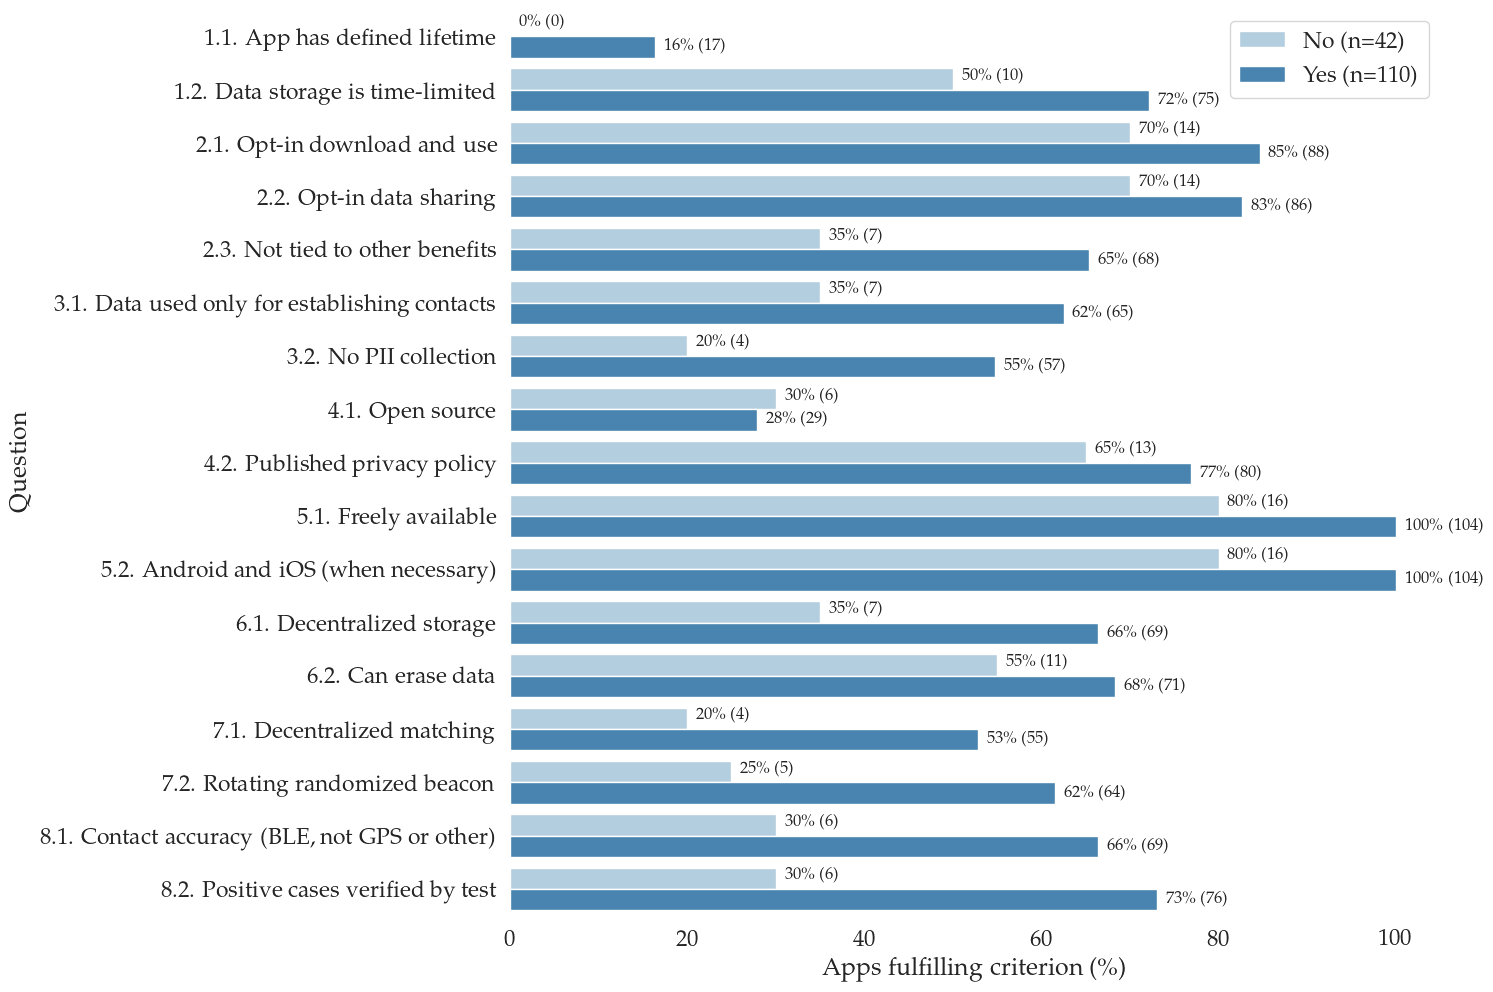

In [26]:
rc('text', usetex=True)
plt.figure(dpi=100, figsize=(12, 12))

splot = sns.barplot(data=gov_vs_nongov, x='mean', y='level_0', hue='government', palette='Blues')
# plt.tight_layout()

plotting.remove_spines(plt.gca())
plt.grid(b=True, which='major', axis='x', color='white')
plt.legend(title="Government-backed")
plt.ylabel("Question")
plt.xlabel("Apps fulfilling criterion (\%)")
plt.gca().xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0%}"))

question2ypos = {lab.get_text(): t for t, lab in zip(*plt.yticks())}
xoff = 0.01
for i, row in gov_vs_nongov.iterrows():
    ypos = question2ypos[row['level_0']]
    pct = row['mean']
    count = row['sum']
    gov = row['government']
    yoff = -0.25 if gov == 'no' else 0.2
    plt.annotate(f'{pct * 100:.0f}\% ({int(count)})', (pct + xoff, ypos + yoff), va='center', size=12)
    
handles, labels = plt.gca().get_legend_handles_labels()
labels = [f'{i.capitalize()} (n={len(df_scored.query("government == @i"))})' for i in labels]
plt.legend(handles, labels)

## Saving data with question names

In [27]:
(
    df_scored
    .replace(to_replace={c: {0: 'no', 1: 'yes'} for c in list(col2question.keys()) + ['has_protocol']})
    .rename(columns=col2question)
    .to_csv(config.data / 'apps_scored_displaynames.csv', index=False)
)